# Workout Analysis

### Input

This notebook starts by loading ../data/cleaned_data.csv. This file is generated as output from the munge notebook. <br>
The file will be in the following format:<br>
**Header** : *"date, exercise, reps, weight, 1RM"*<br>
**Rows**   : *"mm-dd-yyyy, exercise name, reps, weight, 1RM"*<br><br>
### Graphing Functions
*singleplot(dataframe, string exercise_name)*: Generates two plots, the first being time vs exercise max weight, and the second including time vs exercise calculated one rep max uszing the Epley formula.

*multiplot(dataframe, list exercise_names)*: Generates two plots, the first is a line graph time vs exercise max wt for all exercises included in the list. The second, being simlar to above, is time vs one rep max for each exercise.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
df = pd.read_csv('../data/cleaned_data.csv')

In [12]:
df.head()

,date,exercise,reps,weight,1RM
0,2019-02-03,bench press,12.0,70.0,98.0
1,2019-02-03,bench press,8.0,90.0,114.0
2,2019-02-03,bench press,8.0,90.0,114.0
3,2019-02-03,bench press,8.0,90.0,114.0
4,2019-02-03,bench press,6.0,100.0,120.0


In [13]:
def singleplot(df, name):
    fig, ax = plt.subplots(figsize=(12,8))
    ax = grouped.unstack(-2)[name].dropna().plot(ax=ax,label=name)
    plt.legend(loc='best')
    
def multiplot(df, names):
    #plots time vs muscle group in [chest, tricep, back, bicep, shoulders, legs]
    grouped_wt = cleaned_df.groupby(['exercise','date'])['weight'].max()
    grouped_1rm = cleaned_df.groupby(['exercise','date'])['1RM'].max()

    fig, axes = plt.subplots(1,2,figsize=(12,8))
    for x in names:
        axes[0] = grouped_wt.unstack(-2)[x].dropna().plot(ax=axes[0],label=x)
        axes[1] = grouped_1rm.unstack(-2)[x].dropna().plot(ax=axes[1],label=x)
        
    axes[0].legend(loc='best')
    axes[0].set_title('Exercise Max Set Weight (lbs)', fontsize=16)
    axes[0].set_ylabel('Weight (lbs)', fontsize=16)
    axes[0].set_xlabel('Date', fontsize=16)
    
    axes[1].legend(loc='best')
    axes[1].set_title('Exercise Max 1RM (lbs)', fontsize=16)
    axes[1].set_xlabel('Date', fontsize=16)

In [189]:
#Which exercise have you done the most?
vc = df.exercise.value_counts()
vc


bench press                         71
lat pulldown                        56
cable row                           46
cable pushdown                      35
dumbbell incline press              30
cable pullover                      28
barbell curl                        23
squat                               19
dumbbell curl                       17
deadlift                            16
machine fly                         13
barbell reverse tricep extension    12
cable curl                          11
smith squat                         10
barbell incline press               10
smith bent row                       9
close grip bench press               9
smith dl                             8
standing barbell shoulder press      8
smith seated press                   6
sitting dumbbell shoulder press      4
hammer curl                          4
dumbbell bench press                 4
standing dumbbell shoulder press     4
bulgarian split squat                3
cable side raise         

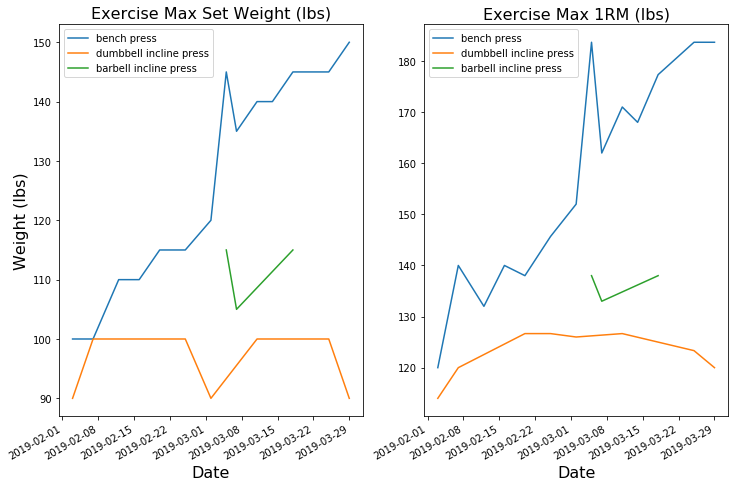

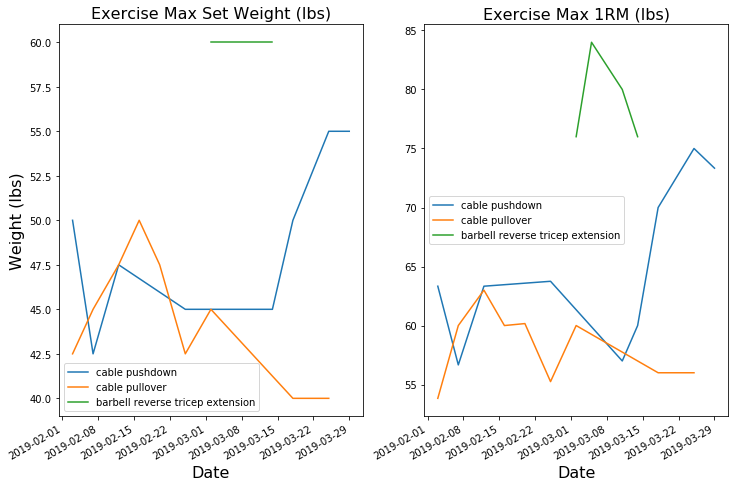

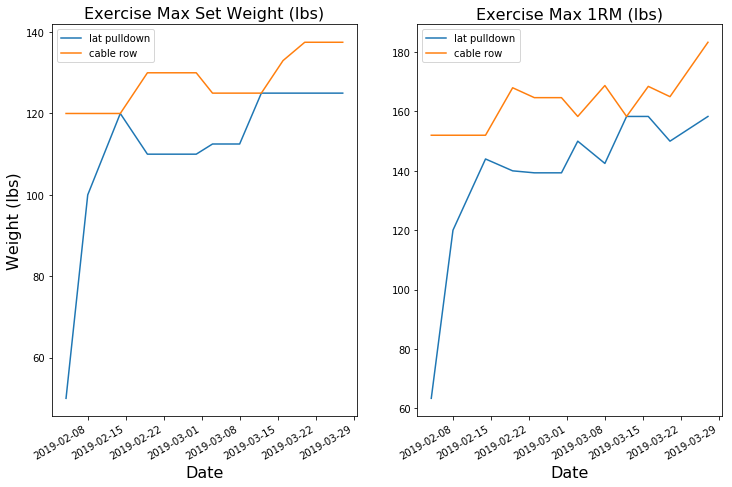

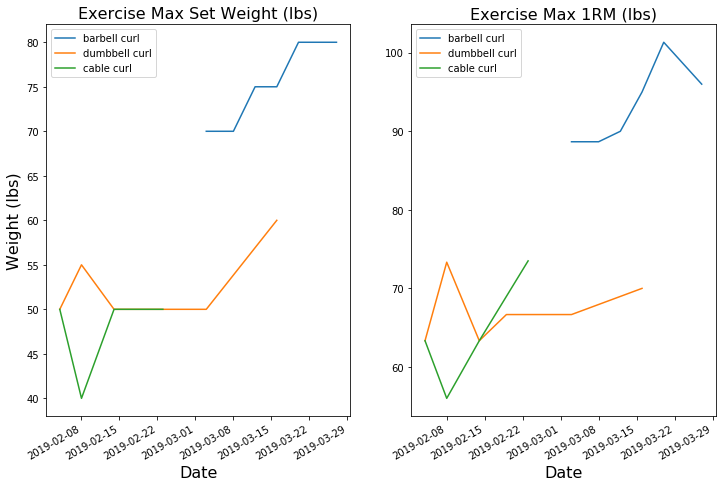

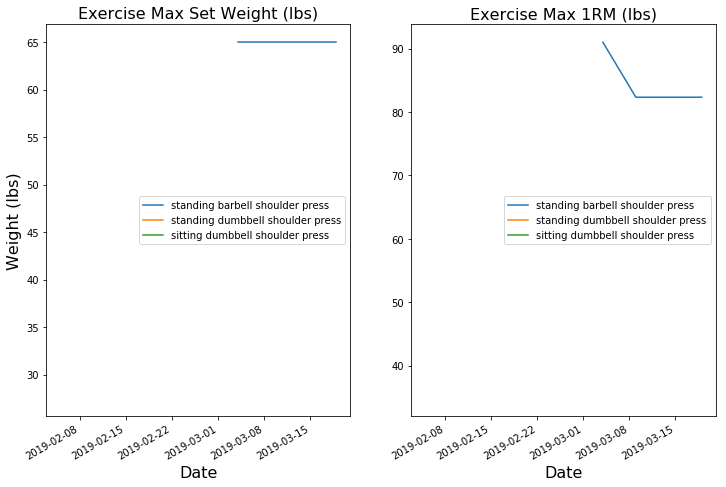

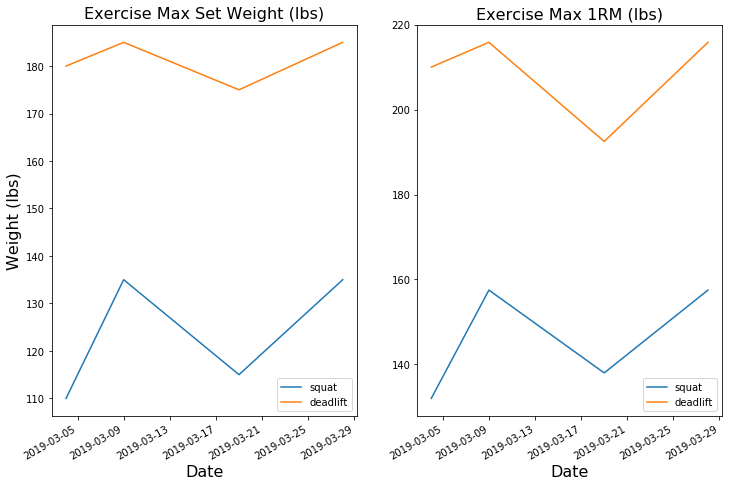

In [190]:
benchmarks = {'chest' : ('bench press','dumbbell incline press','barbell incline press'),
              'tricep' : ('cable pushdown','cable pullover','barbell reverse tricep extension'),
              'back' :['lat pulldown','cable row'],
              'bicep' : ['barbell curl','dumbbell curl','cable curl'],
              'shoulder' : ['standing barbell shoulder press', 
                          'standing dumbbell shoulder press', 
                          'sitting dumbbell shoulder press'],
              'legs' : ['squat','deadlift']}
for key, value in benchmarks.items():
    multiplot(df, value)